# XGBoost快速入门——与scikit-learn一起使用-split-early stop

In [1]:
# 运行 xgboost安装包中的示例程序
import xgboost as xgb
from xgboost import XGBClassifier

# 加载LibSVM格式数据模块
from sklearn.datasets import load_svmlight_file

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from matplotlib import pyplot

## 数据读取

scikit-learn支持多种格式的数据，包括LibSVM格式数据
XGBoost可以加载libsvm格式的文本数据，libsvm的文件格式（稀疏特征）如下：
1 101:1.2 102:0.03
0 1:2.1 10001:300 10002:400
...

每一行表示一个样本，第一行的开头的“1”是样本的标签。“101”和“102”为特征索引，'1.2'和'0.03' 为特征的值。
在两类分类中，用“1”表示正样本，用“0” 表示负样本。也支持[0,1]表示概率用来做标签，表示为正样本的概率。

下面的示例数据需要我们通过一些蘑菇的若干属性判断这个品种是否有毒。
UCI数据描述：http://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/ ，
每个样本描述了蘑菇的22个属性，比如形状、气味等等(加工成libsvm格式后变成了126维特征)，然后给出了这个蘑菇是否可食用。其中6513个样本做训练，1611个样本做测试。


In [2]:
# read in data，数据在xgboost安装的路径下的demo目录,现在copy到代码目录下的data目录
my_workpath = './data/'
X_train,y_train = load_svmlight_file(my_workpath + 'agaricus.txt.train')
X_test,y_test = load_svmlight_file(my_workpath + 'agaricus.txt.test')


## 训练集-校验集分离
假设我们取1/3的训练数据做为校验数据
ps: 为什么要校验？

In [3]:
# split data into train and test sets, 1/3的训练数据作为校验数据
seed = 7
test_size = 0.33
X_train_part, X_validate, y_train_part, y_validate= train_test_split(X_train, y_train, test_size=test_size,
    random_state=seed)

X_train_part.shape
X_validate.shape

(2150, 126)

## 训练参数设置

max_depth： 树的最大深度。缺省值为6，取值范围为：[1,∞]
eta：为了防止过拟合，更新过程中用到的收缩步长。在每次提升计算之后，算法会直接获得新特征的权重。 eta通过缩减特征的权重使提升计算过程更加保守。缺省值为0.3，取值范围为：[0,1]
silent：取0时表示打印出运行时信息，取1时表示以缄默方式运行，不打印运行时信息。缺省值为0
objective： 定义学习任务及相应的学习目标，“binary:logistic” 表示二分类的逻辑回归问题，输出为概率。

其他参数取默认值。

In [4]:
# specify parameters via map
param = {'max_depth':2, 'eta':1, 'silent':0, 'objective':'binary:logistic' }
print param

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(param)? (<ipython-input-4-d2bbf3abdb27>, line 3)

## 训练模型

有了参数列表和数据就可以训练模型了 

In [5]:
# 设置boosting迭代计算次数
num_round = 100

#bst = XGBClassifier(param)
#bst = XGBClassifier()
bst =XGBClassifier(max_depth=2, learning_rate=0.1, n_estimators=num_round, silent=True, objective='binary:logistic')

#eval_set = [(X_train_part, y_train_part), (X_validation, y_validation)]
#bst.fit(X_train_part, y_train_part, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False)

eval_set =[(X_validate, y_validate)]
bst.fit(X_train_part, y_train_part, early_stopping_rounds=10, eval_metric="error",
    eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.048372
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.042326
[2]	validation_0-error:0.048372
[3]	validation_0-error:0.042326
[4]	validation_0-error:0.042326
[5]	validation_0-error:0.042326
[6]	validation_0-error:0.023256
[7]	validation_0-error:0.042326
[8]	validation_0-error:0.042326
[9]	validation_0-error:0.023256
[10]	validation_0-error:0.006512
[11]	validation_0-error:0.017674
[12]	validation_0-error:0.017674
[13]	validation_0-error:0.017674
[14]	validation_0-error:0.017674
[15]	validation_0-error:0.017674
[16]	validation_0-error:0.017674
[17]	validation_0-error:0.017674
[18]	validation_0-error:0.024651
[19]	validation_0-error:0.020465
[20]	validation_0-error:0.020465
Stopping. Best iteration:
[10]	validation_0-error:0.006512



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=1, verbosity=1)

模型在每次校验集上的性能存在模型中，可用来进一步进行分析 model.evals result() 返回一个字典：评估数据集和分数

显示学习曲线

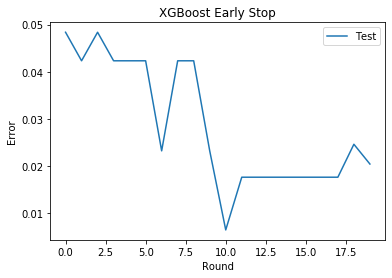

In [6]:
# retrieve performance metrics
results = bst.evals_result()
#print(results)

epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Test')
ax.legend()
pyplot.ylabel('Error')
pyplot.xlabel('Round')
pyplot.title('XGBoost Early Stop')
pyplot.show()


## 测试

模型训练好后，可以用训练好的模型对测试数据进行预测

XGBoost预测的输出是概率，输出值是样本为第一类的概率。我们需要将概率值转换为0或1。

In [7]:
# make prediction
preds = bst.predict(X_test)
predictions = [round(value) for value in preds]

test_accuracy = accuracy_score(y_test, predictions)
print("Test Accuracy: %.2f%%" % (test_accuracy * 100.0))

Test Accuracy: 99.44%
